<a href="https://colab.research.google.com/github/Jerry0209/FundamentalLearningEPFL/blob/main/TP8/kernel-and-backprop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kernel regression

**What you will learn today**: You will learn how to implement kernel regression. First we analyze a synthetic dataset: you will build the feature map associated with different kernels and we see how the learning performance can be different. As always after having understood the theoretical insights we step on to real-dataset problem: you can play using our dear friend sklearn to implement Kernel Ridge Regression, with a kernel of your choice.

**Important note!** There are 2 evaluated questions! Make sure to answer them to get the points.

# 1) KRR from scratch

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Remember first lecture?  Let us use pandas for handling synthetic dataset

In [2]:
# data = pd.read_csv('dataTP8.csv')
data = pd.read_csv("https://raw.githubusercontent.com/Jerry0209/FundamentalLearningEPFL/main/TP8/dataTP8.csv")

In [3]:
x,y = np.array(data['X']), np.array(data['Y'])

Let's see how it looks like

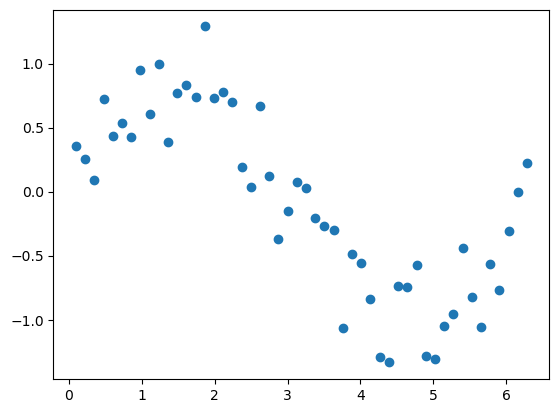

In [4]:
plt.plot(x,y,'o')

It does not seem a bad idea to use a polynomial fitting here. We have introduced in the theoretical lectures kernel methods: $$K(x,y) = {\phi(x)}^T{\phi(y)}$$

Let us pick for the first part of the analysis a feature map of the form:
$$ \phi_k^{(p)}(x) = x^k  \,\,\,\,\,\,\,\, k=1 \dots p $$

You may have studied this under the name *linear basis regression*.

The tools we need once we have mapped the datapoints in feature space are the usual one of linear regression as we know and all will be straight-forward.
We will study the behaviour as the degree $p$ varies, this will vary the complexity of the fitting model leading us to our usual bias-variance tradeoff consideration.

In [5]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    x_pol = []

    for i in range(0,len(x)):
        x_pol_ele = np.array([x[i]**j for j in range(0,degree+1)]) # For each element to generate a polynomial feature vector (design matrix)
        x_pol.append(x_pol_ele)
    return np.array(x_pol)

def ridge_regression(y, X, lambda_): # Normal ridge regression with L2
    """implement ridge regression."""
    Xt = np.transpose(X)
    I = np.eye(len(Xt))
    w =  np.linalg.solve(Xt@X + (2*lambda_*len(y))*I,Xt@y) # get w by dL(w)/w = 0
    mse = (1/(2*len(y)))*np.sum((y-np.matmul(X,w))**2) # Calculate MSE
    return mse,w

def polynomial_regression(x,y,degrees,lambda_): # Find argmin L of w
    num = len(degrees) # different degrees
    fig, axs = plt.subplots(num,figsize=(15,15)) ; i =-1
    for degree in (degrees):
        i+=1   ; phi = build_poly(x, degree) # build feature vector

        mse , weights = ridge_regression(y, phi,lambda_) # do regression for one degree and then test
        rmse = np.sqrt(2*mse)

        print("Processing {j}th experiment, degree={d}, rmse={loss}".format(
              j=i + 1, d=degree, loss=rmse))
        # print(weights)
        # plot fit
        # fhat = np.dot(phi,weights)
        xvals = np.arange(min(x) - 0.1, max(x) + 0.1, 0.1)
        phi = build_poly(xvals, degree) ; fhat = np.dot(phi,weights)
        axs[i].plot(x,
            y, 'o',label=f'Degree={degree} -- Data')
        axs[i].plot(xvals,
            fhat,label=f'Fit')
        axs[i].set_ylim([-1.4,1.4])
        axs[i].legend()
    # plt.tight_layout()

    # How to optimize: change feature maps
    # find a function
    #


Processing 1th experiment, degree=5, rmse=0.25454356450400506
Processing 2th experiment, degree=12, rmse=0.24434219815255015
Processing 3th experiment, degree=20, rmse=0.2440756504736535
Processing 4th experiment, degree=50, rmse=0.22714020370685095
Processing 5th experiment, degree=80, rmse=0.21272357960262692
Processing 6th experiment, degree=120, rmse=0.2196820199235788
Processing 7th experiment, degree=160, rmse=0.21108052043721365


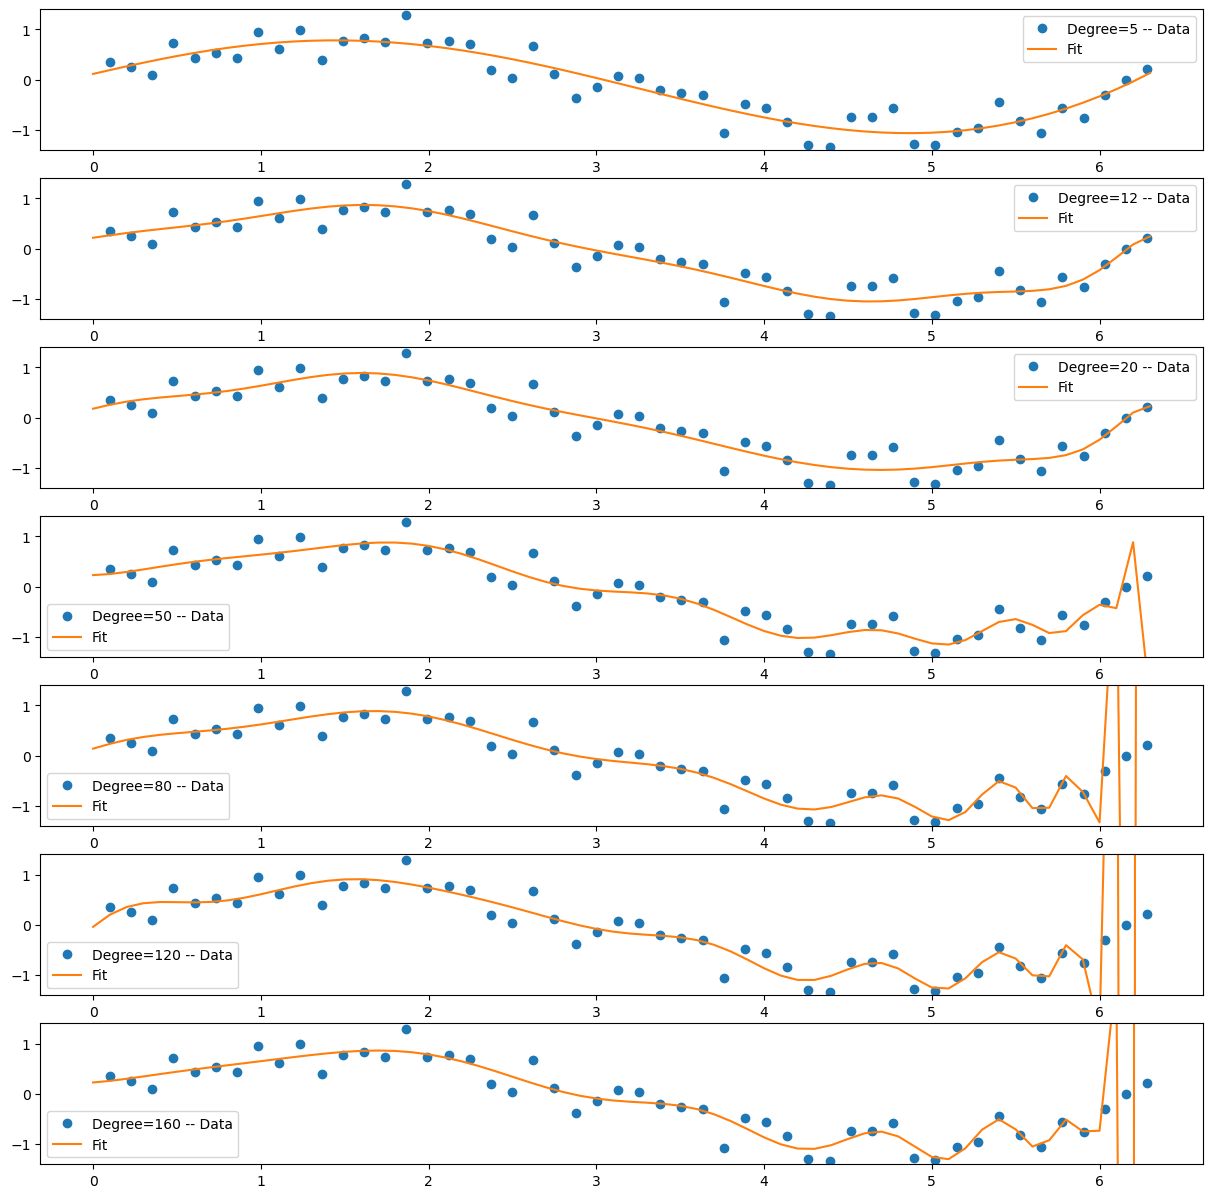

In [6]:
degrees = [5,  12, 20,50,80,120,160] ; lambda_ = 10e-6
polynomial_regression(x,y,degrees,lambda_)

We clearly see that by choosing a value of the degree too high we start to have bad fitting (i.e. overfitting). This feature map is not building a good kernel for studying the data.

It is interesting to understand if we can build another feature map, always in a polynomial fashion, that is able to having good learning rates.

First let's introduce some functions to split data in training and testing dataset to evaluate the performance of the model.

In [7]:
def split_data(x, y, ratio, seed=1):
    # set seed
    np.random.seed(seed)
    # ***************************************************
    index = np.arange(0,len(x))
    index_train = np.random.choice(index, int(ratio*len(x)), replace=False)

    training_x = x[index_train]
    training_y = y[index_train]
    test_x = x[[i for i in range(len(x)) if i not in index_train]]
    test_y = y[[i for i in range(len(y)) if i not in index_train]]

    return training_x, training_y, test_x, test_y

    ## Gamma: large - exp -> 1, small -> small value of x, test error goes error with small error
    ## Lambda: error decreases in first and increases in second graph

## Exercise
* Implement kernel regression with the feature map parametrized by $\gamma$ which we encode with the codework *rbf*:

$$ \phi_k^{(p)}(x) = e^{\frac{-x^2}{\gamma}}\frac{x^k}{k!}  \,\,\,\,\,\,\,\, k=1 \dots p $$
* Study the behaviour as a function of $\lambda$ of the learning curves (test error and training error) and compare with what you would see with the previous feature map.
* What do you conclude?



Let us implement first the function for finding the learning curves of KRR.

In [8]:
## I should be able to do this by myself: curves with different fixed gamma, varying lambda
## This is RBF, parameter I can turn is the gamma and dimension

## TA's implementation

def ridge_regression_learning_curves(x, y, degree, ratio,lambdas, seed,choice , gamma):
    """ridge regression demo."""
    # define parameter
    training_x,training_y,test_x,test_y = split_data(x, y, ratio, seed)

    phi_train = build_poly(training_x, degree,choice,gamma)
    phi_test = build_poly(test_x, degree,choice,gamma)

    rmse_tr = []
    rmse_te = []
    for _, lambda_ in enumerate(lambdas):
        mse_train,w = ridge_regression(training_y, phi_train, lambda_)
        rmse_tr.append(np.sqrt(2*mse_train))

        mse_test = (1/(2*len(test_y)))*np.sum((test_y-np.matmul(phi_test,w))**2)
        rmse_te.append(np.sqrt(2*mse_test))

        # print("proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
        #        p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))

    return rmse_tr , rmse_te

# 2) Kernel methods using Sklearn

We have seen how to build Kernel Ridge Regression (KRR) from scratch starting from the feature map. The idea to map datapoint in an higher dimensional space (i.e. kernel trick) can be used also in classification task. We will consider again our old friend MNIST, we will consider SVC (Support Vector Classification). We will see that, at stake with previous lecture, *SVC* will accept the parameter *kernel* to choose in which space mapping our datapoints.

In [9]:
import time

from sklearn.datasets import fetch_openml # MNIST data
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

print(__doc__)

# Turn down for faster convergence
t0 = time.time()
train_size = 9000 # 60000
test_size = 1500 # 10000

### load MNIST data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', return_X_y=True, as_frame=False)
X = np.array(X)[:train_size+test_size]
y = np.array(y)[:train_size+test_size]


Automatically created module for IPython interactive environment


Let's plot an image to see how it looks like with plt.imshow.

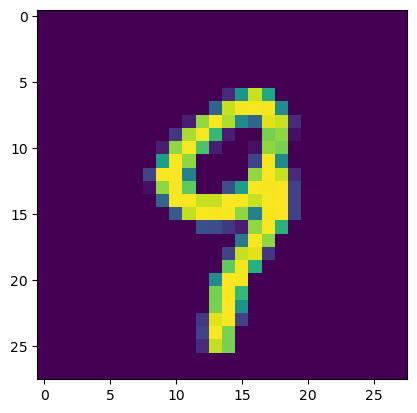

In [10]:
plt.imshow(X[6542,:].reshape(28,28))

We shuffle the data and we do the test-train splitting.

In [11]:
# shuffle data
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))
# pick training and test data sets
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=train_size,test_size=test_size)

### Exercise [EVALUATED 1]
Use `sklearn.svm.SVC` to classify the MNIST dataset. Use the following kernels: `linear`, `poly`, `rbf`, `sigmoid`. For each kernel do a cross-validation to find the best hyperparameters. Use `GridSearchCV` to do that.
Finally return the bes global model and the best kernel for the dataset.

In [12]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import ShuffleSplit
## Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.

## SVC: C-Support Vector Classification

clf_svc = svm.SVC(kernel='linear', tol=0.1, C=1.0, max_iter=1500, random_state=42)
# clf_linear_svc = svm.SVC(kernel='linear', tol=0.1, C=1.0, max_iter=1500, random_state=42)
# clf_poly_svc = svm.SVC(kernel='poly', tol=0.1, C=1.0, max_iter=1500, random_state=42)
# clf_rbf_svc = svm.SVC(kernel='rbf', tol=0.1, C=1.0, max_iter=1500, random_state=42)
# clf_sigmoid_svc = svm.SVC(kernel='sigmoid', tol=0.1, C=1.0, max_iter=1500, random_state=42)

#--- Make a Pre-processing + Fitting Pipeline ---#
pipe_svc = make_pipeline(preprocessing.StandardScaler(), clf_svc)
# pipe_linear_svc = make_pipeline(preprocessing.StandardScaler(), clf_linear_svc)
# pipe_poly_svc = make_pipeline(preprocessing.StandardScaler(), clf_poly_svc)
# pipe_rbf_svc = make_pipeline(preprocessing.StandardScaler(), clf_rbf_svc)
# pipe_sigmoid_svc = make_pipeline(preprocessing.StandardScaler(), clf_sigmoid_svc)

#--- Define CV Splitting ---#
cv = ShuffleSplit(n_splits=5, test_size=0.05, random_state=1) # Only 5 sub data sets, boost train

## Cross validation first appears at TP 4, check it, search "CV"
# or from last TP, maybe TP 7

# Set up the grid search
# To know the what paramaters are in the function rbf_svc, just point to it to see it's library and function, then search it online
# Set up possible values of parameters to optimize over
# p_grid = {"C": [1, 10, 100], "gamma": [0.01, 0.1]}
# parameters = [{'degree': np.arange(5, 20)}, {'gamma': np.linspace(1, 100, 30)}]

#--- Define the Parameters to Search ---# (step__parameter)
# param_grid = {"C": np.logspace(-1,2,4), "gamma": np.logspace(-2,-1,2), "kernel": ['linear', 'poly', 'rbf', 'sigmoid']}

c_range = np.logspace(-1, 2, 4)
gamma_range = np.logspace(-2, -1, 2)

param_grid_list = [
    {
        'svc__kernel': ['linear'],
        'svc__C': c_range
    },
    {
        'svc__kernel': ['poly'],
        'svc__C': c_range,
        'svc__gamma': gamma_range,
        'svc__degree': [2, 3, 4]  # poly - degree
    },
    {
        'svc__kernel': ['rbf'],
        'svc__C': c_range,
        'svc__gamma': gamma_range
    },
    {
        'svc__kernel': ['sigmoid'],
        'svc__C': c_range,
        'svc__gamma': gamma_range
    }
]

#--- Define CV ---#
print("Running GridSearchCV...")
t0=time.time()

cv_svc = GridSearchCV(pipe_svc, param_grid_list, scoring='accuracy', cv=cv, n_jobs=-1, verbose=2, return_train_score=True)
# cv_linear_svc = GridSearchCV(pipe_linear_svc, param_grid, scoring='accuracy', cv=cv, n_jobs=-1, verbose=2, return_train_score=True)
# cv_poly_svc = GridSearchCV(pipe_poly_svc, param_grid, scoring='accuracy', cv=cv, n_jobs=-1, verbose=2, return_train_score=True)
# cv_rbf_svc = GridSearchCV(pipe_rbf_svc, param_grid, scoring='accuracy', cv=cv, n_jobs=-1, verbose=2, return_train_score=True)
# cv_sigmoid_svc = GridSearchCV(pipe_sigmoid_svc, param_grid, scoring='accuracy', cv=cv, n_jobs=-1, verbose=2, return_train_score=True)

#--- Run CV ---#
cv_svc.fit(X_train,y_train)
# cv_linear_svc.fit(X_train,y_train)
# cv_poly_svc.fit(X_train,y_train)
# cv_rbf_svc.fit(X_train,y_train)
# cv_sigmoid_svc.fit(X_train,y_train)
# clf = GridSearchCV(rbf_svc, parameters) ## We should choose a parameter contains in a model
# clf.fit(X, y)

# Display run time
run_time = time.time() - t0
print(f"GridSearchCV finished in {run_time:.2f} seconds.")

#--- Record CV Optimizing Hyper-Params ---#
print(f"Best Score (Accuracy): {cv_svc.best_score_:.4f}")
print("Best Parameters Found:")
print(cv_svc.best_params_)
best_clf_svc_model = cv_svc.best_estimator_


# Compute accuracy with optimal C
print("Computing accuracy...")
score_svc_optimized = best_clf_svc_model.score(X_test, y_test)

print("Test score with L2 penalty (Optimized C): %.4f" % score_svc_optimized)

# Print results
# print(clf.best_params_)
# print(clf.cv_results_["mean_test_score"])

# With TA's Notes, plz finish KNN cross validation first



Running GridSearchCV...
Fitting 5 folds for each of 44 candidates, totalling 220 fits


C:\Users\Jerry\anaconda3\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


GridSearchCV finished in 1552.34 seconds.
Best Score (Accuracy): 0.9596
Best Parameters Found:
{'svc__C': np.float64(0.1), 'svc__degree': 3, 'svc__gamma': np.float64(0.01), 'svc__kernel': 'poly'}
Computing accuracy...
Test score with L2 penalty (Optimized C): 0.9613


# Backpropagation from scratch

**What will you learn today**: Backpropagation is the fundamental building block of deep learning, as it allows to automatically compute the gradients of any arbitrary compositional function with a similar computational cost than evaluating it. This makes possible to work with arbitrarily complex neural network architectures, composed of many layers, without the need to manually compute their gradients. Backpropagation is already implemented in all high-level deep learning frameworks, e.g. `PyTorch`, and as such, we would hardly ever need to think of how it works. However, it is a very educational exercise to implement it once in your life, and that is precisely what we will do in this exercise! In particular, you will learn to implement and derive the forward and backward pass of a very simple neural network in pure `numpy`. As a bonus, we will also explore how to approximate the non-convex loss landscape of a neural network by a convex one, and we will learn how to use such approximation to derive intuitions about how different design choices affect the network's behaviour.

# 1) Forward pass
To simplify the exercise, we will only work with a simple architecture, consisting of a feedforward neural network with two fully connected layers, i.e., a single-hidden layer MLP.

![simple_mlp](https://github.com/Jerry0209/FundamentalLearningEPFL/blob/main/TP8/simple_mlp.png?raw=1)

Mathematically, we can write the feedforward computation as:
$$ x_j^{(1)}=\sigma\left(z_j^{(1)}\right)=\sigma\left(\sum_{i=1}^D w_{i,j}^{(1)} x_i^{(0)}+b_j^{(1)}\right), $$
$$ \hat y =\sigma\left(z_1^{(2)}\right)=\sigma\left(\sum_{i=1}^K w_{i,1}^{(2)} x_i^{(1)}+b_1^{(2)}\right),  $$
where $\sigma(\cdot)$ denotes the sigmoid activation function. In the rest of the exercise, we will use $D=4$, and $K=5$.

We can alternatively write the same computation in vector notation
$$ \bf x^{(1)}=\sigma\left(\bf z^{(1)}\right)=\sigma\left(\bf W^{(1)} \bf x^{(0)}+\bf b^{(1)}\right), $$
$$ \hat y=\sigma\left(z^{(2)}\right)=\sigma\left(\bf {w^{(2)}}^\top \bf x^{(1)}+b^{(2)}\right). $$

In general, we will denote the function computed by the neural network as $f_{\bf w}(\bf x)=\hat y$, and use $\bf w$ to represent the vector of all weights in the architecture.

## Exercise


In [ ]:
x = np.array([0.01, 0.02, 0.03, 0.04])
W = {
    "w_1": np.ones((4, 5)),
    "w_2": np.ones(5)
}
y = 1

Then, let's implement the forward pass. If you implement it correctly, you should see that your code can pass the test successfully.

In [ ]:
def simple_feed_forward(x, W):
    # Your code here
    pass

try:
    expected = 0.93244675427215695
    _, _, yours = simple_feed_forward(x, W)
    assert np.sum((yours - expected) ** 2) < 1e-15
    print("Your implementation is correct!")
except:
    print("Your implementation is not correct.")

Your implementation is correct!


## 2) Backward pass

We now have a working implementation of our network! However, if we want to be able to train it using gradient descent, we need to be able to compute its gradient. Let's do that.

We will use the squared error as our loss function, i.e.,
$$\ell(y,\hat y)=\frac{1}{2}(\hat y-y)^2$$


### Exercise
Evaluate the derivative of $\mathcal{L}(\bf w)=\ell(y, f_{\bf w}(\bf x))$ with respect to $w_{i,1}^{(2)}$ and $w_{i,j}^{(1)}$ for a single training sample $(\bf x, y)$, by following the backpropagation algorithm.

### Exercise [EVALUATED 2]
Now that we have derived the backward pass analytically, let's implement it in Python!

*Hint*: You might want to slightly change `simple_feed_forward`.

In [ ]:
def simple_backpropagation(y, x, W):
    """Do backpropagation and get delta_W."""
    # Your code here
    pass

try:
    expected = {
        'w_1': np.array([
            [ -1.06113639e-05,  -1.06113639e-05,  -1.06113639e-05, -1.06113639e-05,  -1.06113639e-05],
            [ -2.12227277e-05,  -2.12227277e-05,  -2.12227277e-05, -2.12227277e-05,  -2.12227277e-05],
            [ -3.18340916e-05,  -3.18340916e-05,  -3.18340916e-05, -3.18340916e-05,  -3.18340916e-05],
            [ -4.24454555e-05,  -4.24454555e-05,  -4.24454555e-05, -4.24454555e-05,  -4.24454555e-05]]),
        'w_2': np.array(
            [-0.00223387, -0.00223387, -0.00223387, -0.00223387, -0.00223387])
    }
    yours = simple_backpropagation(y, x, W)
    assert np.sum(
        [np.sum((yours[key] - expected[key]) ** 2) for key in expected.keys()]) < 1e-15
    print("Your implementation is correct!")
except:
    print("Your implementation is not correct!")

Your implementation is correct!


# 3) Bonus: Effect of regularization

One of the first things we learn about neural networks is that their loss landscape is not convex. This means that analyzing how different design choices will affect their performance precisely is generally very hard. Fortunately, however, many times we can get an intuition of the behaviour of a neural network by taking a few approximations. We will now explore one of those. In particular, we will use some simple approximations to explore what is the effect of regularization on the weights of a neural network.

Let $\bf w$ be the weight vetor of all weights in the neural network, and recall that we do not normally penalize the bias term, so let's ignore it for the rest of our derivations. Furthermore, let $\bf w^\star$ denote a parameter that minimizes the cost function $\mathcal L$ for the given test set (where the cost functions does not include the regularization). We would like to study how the optimal weight changes if we include some regularization.

In order to make the problem tractable, assume that $\mathcal L(\bf w)$ can be locally expanded around the optimal parrameter $\bf w^\star$ in the form
$$\mathcal L(\bf w) =\mathcal L(\bf w^\star)+\frac{1}{2}(\bf w-\bf w^\star)^\top\bf H(\bf w-\bf w^\star),$$
where $\bf H$ denotes the Hessian, whose components are the entries
$$\cfrac{\partial^2 \mathcal{L}}{\partial \bf w_i \partial \bf w_j }$$

Now, let's add a regularization term of the form $\frac{1}{2}\mu\|\bf w\|^2_2$.

## Exercise
1. Show that the optimum weight vector for the regularized problem is given by $$\bf Q(\bf \Lambda+\mu\bf I)^{-1}\bf \Lambda\bf Q^\top \bf w^\star$$ where $\bf H=\bf Q\bf\Lambda\bf Q^\top$ represents the eigenvalue decomposition of the symmetric matrix $\bf H$, i.e., $\bf Q$ is an orthonormal matrix, and $\bf \Lambda$ is a diagonal matrix whose entries are non-negative and decreasing along the diagonal.
2. Show that $(\bf\Lambda+\mu\bf I)^{-1}\bf\Lambda$ is again a diagonal matrix whose $i$-th entry is now $\lambda_i/(\lambda_i+\mu)$.
3. Argue that along the dimensions of the eigenvectors of $\bf H$ that correspond to large eigenvalues, essentially no changes occur in the weights, but that along the dimensions of eigenvectors of very small eigenvalues the weight is drastically decreased.